In [1]:
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
from collections import deque
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

In [2]:
class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

In [3]:
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)
feature_columns = scaler.feature_names_in_
print("Scaler loaded successfully!")

Scaler loaded successfully!


In [4]:
#Load data stream
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [5]:
model = GraphNet(
    in_channels=len(feature_columns),  # number of features
    gcn_hidden=128,           # size of GCN hidden embeddings
    dnn_hidden=64,           # size of hidden layer in the MLP
    out_channels=2           # final classes (0=Benign, 1=Attack)
)
model.load_state_dict(torch.load("GNN_DNN_weights.pth", map_location=torch.device('cpu')))
model.eval()

GraphNet(
  (gcn1): GCNConv(78, 128)
  (gcn2): GCNConv(128, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [6]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [7]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  # list of feature column names
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

replay_buffer = deque(maxlen=2000)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

ema_alpha = 0.3

print("Starting to consume messages...")

for idx, message in enumerate(consumer):
    # Decode and split the incoming message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    row_df[feature_columns] = dynamic_scaler.transform(row_df[feature_columns])

    X_new = row_df[feature_columns].values  # shape: [1, n_features]
    y_new = int(row_df['label'].values[0])
    
    window_data.append((X_new[0], y_new))
    replay_buffer.append((X_new[0], y_new))
    
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")
    
    if len(window_data) == window_size:

        current_window = list(window_data)
        # Sample an equal number of past samples (if available)
        sample_size = min(len(current_window), len(replay_buffer))
        if sample_size > 0:
            # Randomly choose indices from the replay buffer
            replay_indices = np.random.choice(len(replay_buffer), sample_size, replace=False)
            replay_samples = [replay_buffer[i] for i in replay_indices]
        else:
            replay_samples = []
        combined = current_window + replay_samples

        # Extract ground truth and predictions from the window
        X_window = np.array([entry[0] for entry in combined])
        y_window = np.array([entry[1] for entry in combined])

        X_window_df = pd.DataFrame(X_window, columns=feature_columns)
        # For evaluation, generate inputs for each model using its respective scaler.
        X_window_dynamic = dynamic_scaler.transform(X_window_df)
        X_window_static = static_scaler.transform(X_window_df)
        
        k = 5
        knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
        row_idx, col_idx = knn_graph.nonzero()
        edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
        
        X_window_dynamic_tensor = torch.tensor(X_window_dynamic, dtype=torch.float32)
        X_window_static_tensor = torch.tensor(X_window_static, dtype=torch.float32)
        y_window_tensor = torch.tensor(y_window, dtype=torch.long)

        with torch.no_grad():
            dynamic_logits = dynamic_model(X_window_dynamic_tensor, edge_index)
            static_logits = static_model(X_window_static_tensor, edge_index)
        dynamic_preds = dynamic_logits.argmax(dim=1).cpu().numpy()
        static_preds = static_logits.argmax(dim=1).cpu().numpy()


        current_dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
        current_precision = precision_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_recall = recall_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_window, dynamic_preds).ravel() if len(np.unique(y_window)) == 2 else (None, None, None, None)
        if len(np.unique(y_window)) == 2:
            tn, fp, fn, tp = confusion_matrix(y_window, dynamic_preds).ravel()
            fpr_value = fp / (fp + tn) if (fp + tn) > 0 else None
        else:
            fpr_value = None

        print(f"\nWindow complete: Dynamic F1 = {current_dynamic_f1:.3f}, Static F1 = {current_static_f1:.3f}")
        print(f"Dynamic Precision = {current_precision:.3f}, Dynamic Recall = {current_recall:.3f}, Dynamic FPR = {fpr_value}")
        
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)
        window_indices.append(idx // window_size)

        # Retrain if the F1-score is below the threshold and we haven't exceeded max retrains
        if current_dynamic_f1 < 0.75:
            print(f"Dynamic model F1 ({current_dynamic_f1:.3f}) is below threshold. Retraining dynamic model on this window...")

            new_scaler = StandardScaler()
            new_scaler.fit(X_window_df)

            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            X_window_dynamic_scaled = dynamic_scaler.transform(X_window_df)

            knn_graph = kneighbors_graph(X_window_dynamic_scaled, n_neighbors=k, include_self=False)
            row_idx, col_idx = knn_graph.nonzero()
            edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)

            X_window_dynamic_tensor = torch.tensor(X_window_dynamic_scaled, dtype=torch.float32)

            dynamic_model.train()
            optimizer = optim.Adam(dynamic_model.parameters(), lr=0.01)
            criterion = nn.CrossEntropyLoss()
            num_epochs = 80  # adjust as needed
            
            for epoch in range(1, num_epochs + 1):
                optimizer.zero_grad()
                outputs = dynamic_model(X_window_dynamic_tensor, edge_index)  # Forward pass
                loss = criterion(outputs, y_window_tensor)
                loss.backward()
                optimizer.step()
                if epoch % 20 == 0 or epoch == num_epochs:
                    print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4f}")
            dynamic_model.eval()

        # Clear the window for the next batch
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

print("Finished streaming from Kafka or timed out.")

Starting to consume messages...
Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program 


Window complete: Dynamic F1 = 0.561, Static F1 = 0.561
Dynamic Precision = 0.783, Dynamic Recall = 0.679, Dynamic FPR = 0.0
Dynamic model F1 (0.561) is below threshold. Retraining dynamic model on this window...
Epoch 20/80 - Loss: 0.3161
Epoch 40/80 - Loss: 0.2171
Epoch 60/80 - Loss: 0.1473
Epoch 80/80 - Loss: 0.1209
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages

Window complete: Dynamic F1 = 0.729, Static F1 = 0.534
Dynamic Precision = 0.761, Dynamic Recall = 0.756, Dynamic FPR = 0.055891238670694864
Dynamic model F1 (0.729) is below threshold. Retraining dynamic model on this window...
Epoch 20/80 - Loss: 0.4692
Epoch 40/80 - Loss: 0.3800
Epoch 60/80 - Loss: 0.3668
Epoch 80/80 - Loss: 0.3493
Consumed 2000 messages
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Skipping row with i

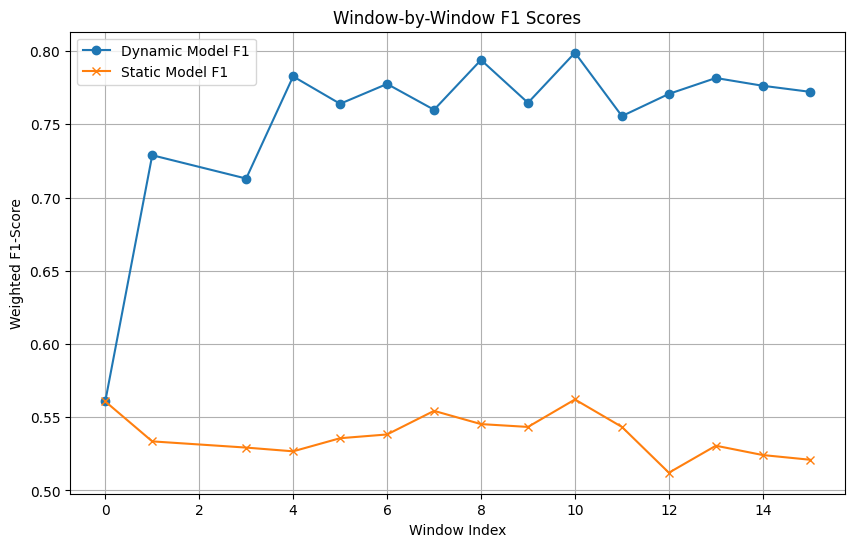

In [8]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()


Dynamic model performs much better than static model